`Importation des librairies `

In [153]:
import numpy as np 
import pandas as pd 
import seaborn as sns 
import requests 
import  matplotlib.pyplot as plt 
import os
import pickle 

from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer, make_column_selector

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import GridSearchCV, cross_val_score, StratifiedKFold


`Chargement de la dataset pour l'analyse`

In [2]:
def load_data(path, urls):
    if  not os.path.exists(path):
        os.mkdir(path)

    for url in urls:
        data = requests.get(url).content 
        filename = os.path.join(path, os.path.basename(url))
        with open(filename, "wb") as file:
            file.write(data)

urls = ["http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names",
        "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.test"]

load_data('data', urls)


`Recupération de la dataset`

In [3]:

columns = ["age", "workClass", "fnlwgt", "education", "education_num", "marital_status", "occupation", "relationship", "race", "sex", "capital_gain",
           "capital_loss", "hours_per_week", "native_country", "income"]

train_data = pd.read_csv('data/adult.data', names = columns, sep=' *, *', na_values='?', engine='python')
test_data = pd.read_csv('data/adult.test', names = columns, sep=' *, *', skiprows =1, na_values='?', engine='python')

train_data.head()


,age,workClass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [4]:
test_data.head()

,age,workClass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,25,Private,226802,11th,7,Never-married,Machine-op-inspct,Own-child,Black,Male,0,0,40,United-States,<=50K.
1,38,Private,89814,HS-grad,9,Married-civ-spouse,Farming-fishing,Husband,White,Male,0,0,50,United-States,<=50K.
2,28,Local-gov,336951,Assoc-acdm,12,Married-civ-spouse,Protective-serv,Husband,White,Male,0,0,40,United-States,>50K.
3,44,Private,160323,Some-college,10,Married-civ-spouse,Machine-op-inspct,Husband,Black,Male,7688,0,40,United-States,>50K.
4,18,NaN,103497,Some-college,10,Never-married,NaN,Own-child,White,Female,0,0,30,United-States,<=50K.


`Analyses exploratoires de la Dataset`

In [5]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workClass       30725 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education_num   32561 non-null  int64 
 5   marital_status  32561 non-null  object
 6   occupation      30718 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital_gain    32561 non-null  int64 
 11  capital_loss    32561 non-null  int64 
 12  hours_per_week  32561 non-null  int64 
 13  native_country  31978 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


In [6]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16281 entries, 0 to 16280
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             16281 non-null  int64 
 1   workClass       15318 non-null  object
 2   fnlwgt          16281 non-null  int64 
 3   education       16281 non-null  object
 4   education_num   16281 non-null  int64 
 5   marital_status  16281 non-null  object
 6   occupation      15315 non-null  object
 7   relationship    16281 non-null  object
 8   race            16281 non-null  object
 9   sex             16281 non-null  object
 10  capital_gain    16281 non-null  int64 
 11  capital_loss    16281 non-null  int64 
 12  hours_per_week  16281 non-null  int64 
 13  native_country  16007 non-null  object
 14  income          16281 non-null  object
dtypes: int64(6), object(9)
memory usage: 1.9+ MB


Text(0.5, 1.0, 'NaNs dans le test_dataSet')

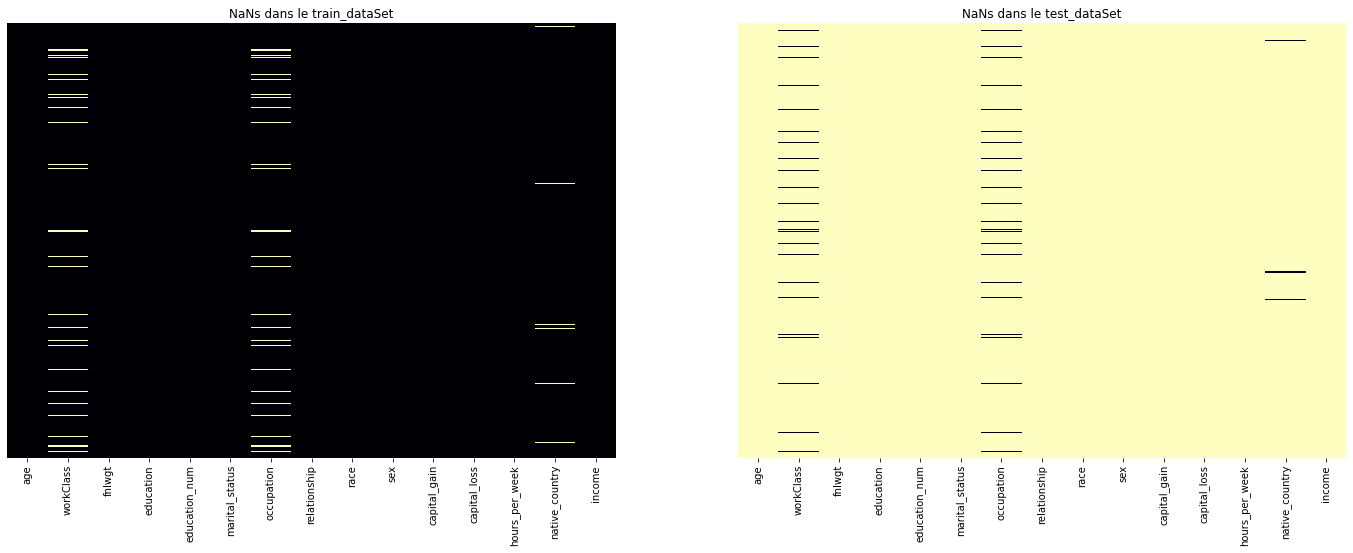

In [7]:
fig, ax = plt.subplots(1,2, figsize=(24,8))
sns.heatmap(train_data.isnull(), yticklabels= False, cmap='magma', ax = ax[0], cbar= False)
ax[0].set_title("NaNs dans le train_dataSet")
sns.heatmap(test_data.isnull(), yticklabels= False, cmap='magma_r', ax = ax[1], cbar=False)
ax[1].set_title("NaNs dans le test_dataSet")

On observe que les variables workclass,occupation et native_country qui pressentent de valeur manquantes. Ces dernières seront gérées par la suite 

In [8]:
varcat = train_data.select_dtypes(include=['object'])
varcat.columns

Index(['workClass', 'education', 'marital_status', 'occupation',
       'relationship', 'race', 'sex', 'native_country', 'income'],
      dtype='object')

In [9]:
varnum = train_data.select_dtypes(exclude=['object'])
varnum.columns

Index(['age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss',
       'hours_per_week'],
      dtype='object')

`Visualisation des données`

Variables numériques

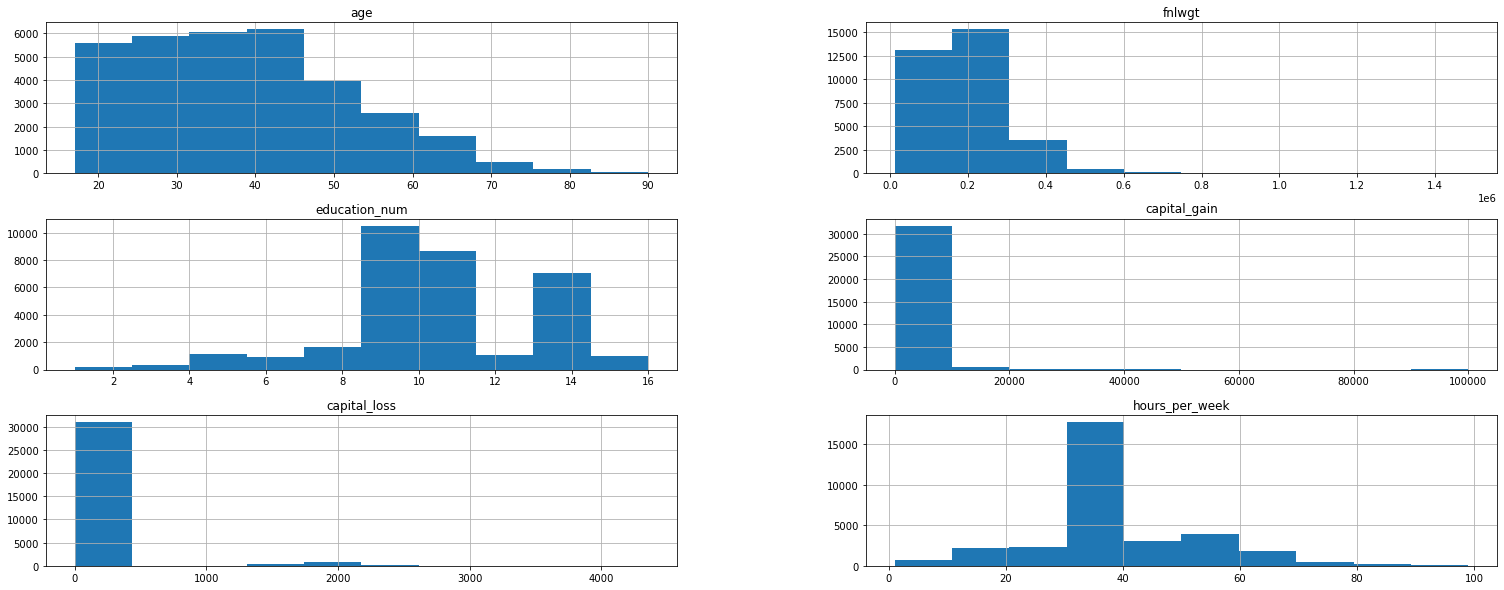

In [20]:
varnum.hist(figsize=(26,10));

Variables catégorielles

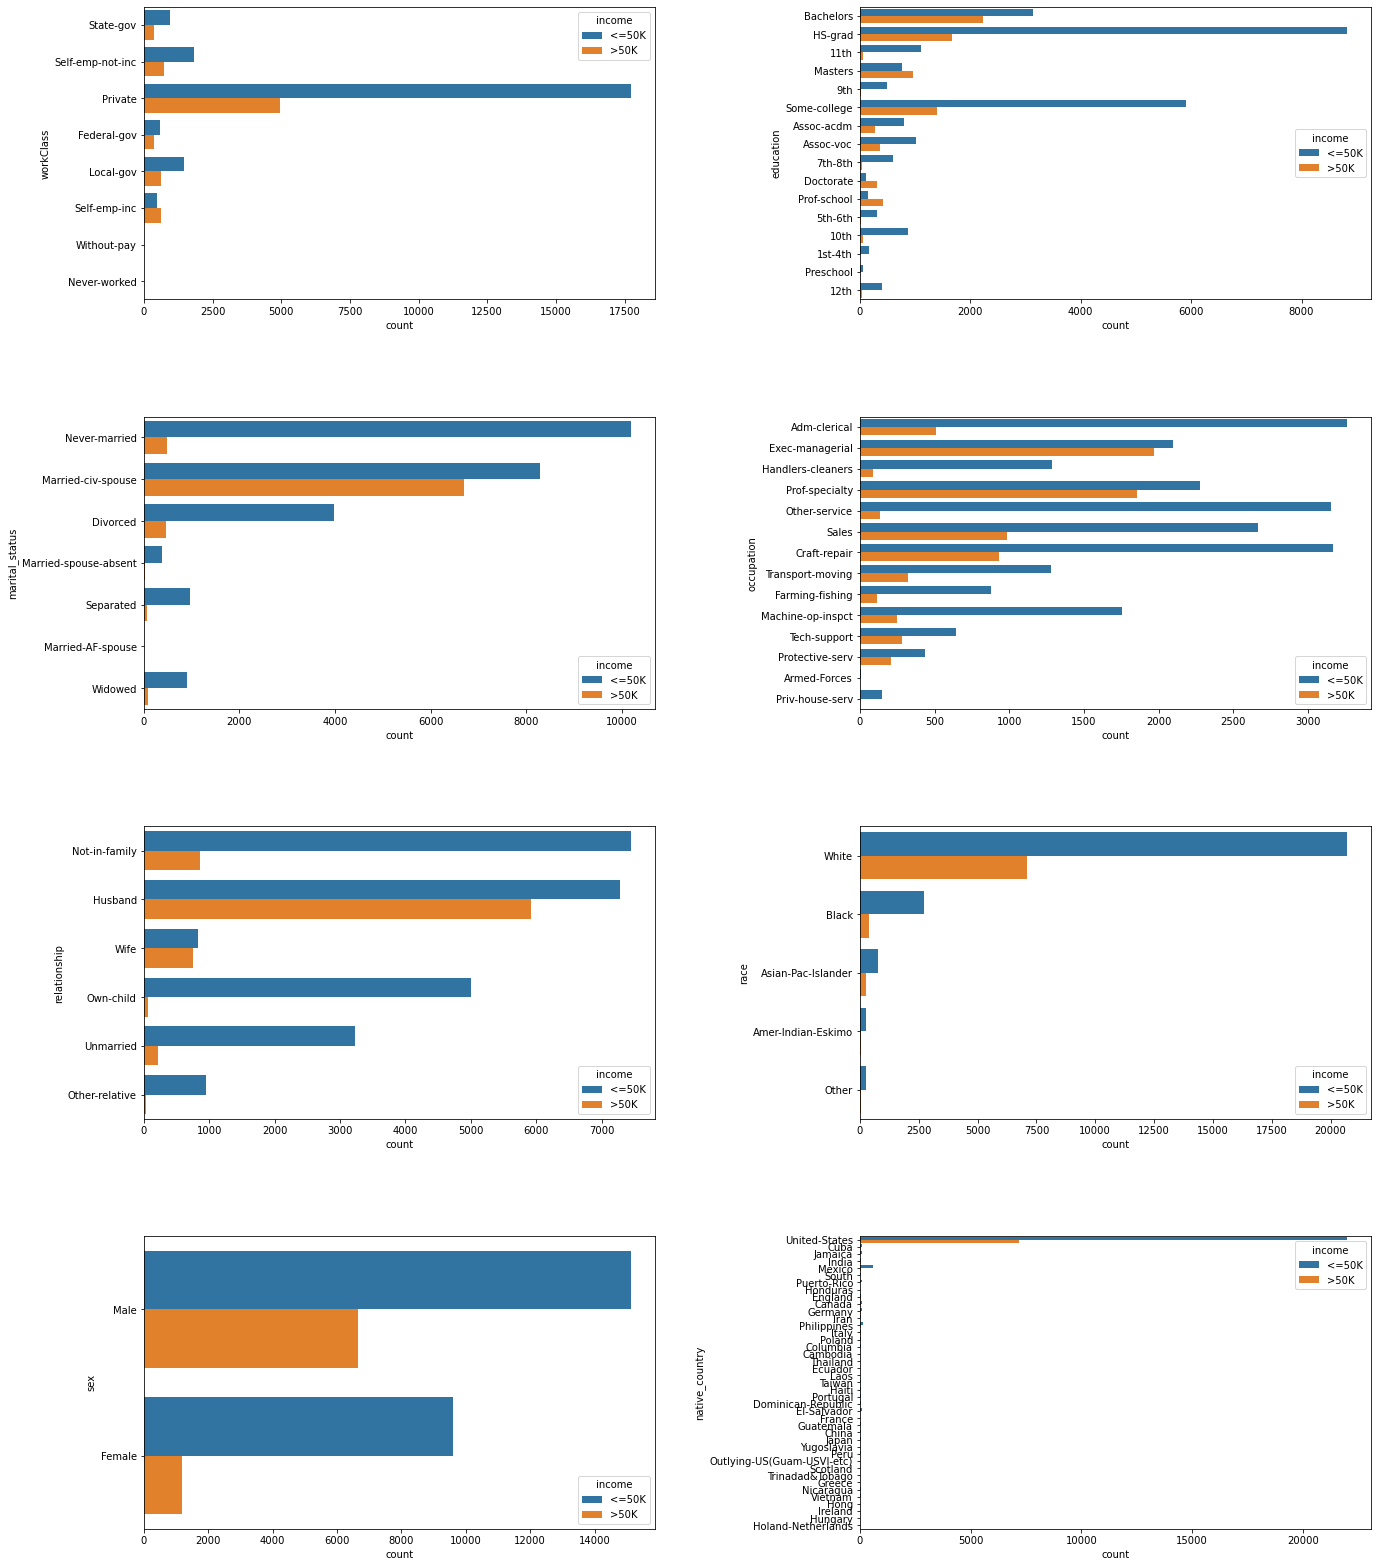

In [26]:
fig = plt.figure(figsize =(22,28))
plt.subplots_adjust(hspace=0.4, wspace = 0.4)
for i in range(varcat.shape[1] -1):
    var = varcat.columns[i]
    fig.add_subplot(4,2, i+1)
    sns.countplot(y=var, hue='income', data=varcat)


On remarque les variables comme `native_country`, `workclass` et `occupation` contiennent des valeurs manquantes. La gestion de ces dernières sera faite par `imputation des valeurs les plus fréquentes` via les pipelines.

`Creation de la matrice X et du vecteur y avec Nettoyage des données`

In [30]:
y_train = train_data['income'].apply(lambda x: 0 if x=='<=50K'else 1) # dummies sur la variable income dans la data_train
y_test = test_data['income'].apply(lambda x: 0 if x=='<=50K.' else 1) # dummies sur la variable income dans la data_test

Pour notre matrice X les variables `fnlwgt`, `eductaion` ne seront pas prises en compte

In [36]:
X_train = train_data.drop(['fnlwgt', 'education','income'], axis=1)
X_test = test_data.drop(['fnlwgt', 'education','income'], axis=1)


print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)
print(y_train.value_counts(), '\n', y_test.value_counts())

(32561, 12) (16281, 12) (32561,) (16281,)
0    24720
1     7841
Name: income, dtype: int64 
 0    12435
1     3846
Name: income, dtype: int64


Pour le pipeline, on utilisera l'impuation des valeurs les plus fréquentes.

In [43]:
varcat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')), # les valeurs plus fréquentes
    ('encoder', OneHotEncoder(drop='first')) # les dummies sur les variables catégorielles
])

In [46]:
# Préprocessing avec les Columselector pour chaque type de variable

preprocessor = ColumnTransformer(transformers=[
    ('num', StandardScaler(), make_column_selector(dtype_include=np.number)),
    ('cat', varcat_pipeline, make_column_selector(dtype_exclude=np.number))
])

On ajuste après notre preprocesseur avec notre data

In [47]:
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

`Entrainement du modele `

In [72]:
reglog = LogisticRegression(solver = "liblinear", max_iter = 1000,)

In [73]:
reglog.fit(X_train_processed, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [79]:
y_pred = reglog.predict(X_test_processed)

In [80]:
print('train=', round(reglog.score(X_train_processed, y_train), 5), 'et le test=', round(reglog.score(X_test_processed, y_test),5))

train= 0.8516 et le test= 0.85228


<AxesSubplot:>

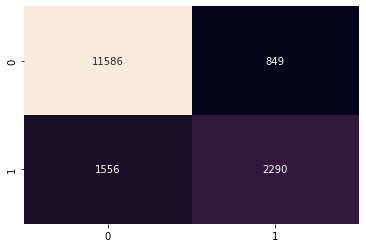

In [81]:

sns.heatmap(confusion_matrix(y_test, y_pred), annot= True, cbar= False, fmt='d')

In [76]:
print(classification_report(y_test, reglog.predict(X_test_processed)))

              precision    recall  f1-score   support

           0       0.88      0.93      0.91     12435
           1       0.73      0.60      0.66      3846

    accuracy                           0.85     16281
   macro avg       0.81      0.76      0.78     16281
weighted avg       0.85      0.85      0.85     16281



Etant donné qu'on va évaluer plusieurs modéles, ce serait plus parlant de définir une fonction pour tester chacun des modeles

In [85]:
reglog.predict_proba(X_test_processed)[:,1]

array([0.00268855, 0.11883599, 0.45665349, ..., 0.6229757 , 0.25508607,
       0.8115719 ])

In [157]:
def evaluation_model (model):
    y_pred = model.predict(X_test_processed)
    proba_1 = model.predict_proba(X_test_processed)[:,1]
    fpr, tpr, thresholds = roc_curve(y_test, proba_1, pos_label =1, drop_intermediate=False)
    aucf = auc(fpr, tpr)
    cm = confusion_matrix(y_test, y_pred)
    accuracy =accuracy_score(y_test, y_pred)
    precision, rappel = precision_recall_fscore_support(y_test, y_pred, pos_label =1, average='macro')[0:2]

    fig , (ax1, ax2) = plt.subplots(1, 2, figsize=(20,9))
    ax1.plot([0,1], [0,1], 'k--')
    ax1.plot(fpr, tpr, label='auc=%1.5f' % aucf)
    ax1.set_title("Courbe ROC")
    ax1.text(0.5, 0.3, "Plus mauvais que\nle hasard dans\ncette zone")
    ax1.text(0.3, 0.6, "Meilleur que\nle hasard dans\ncette zone")
    ax1.legend()

    sns.heatmap(cm, annot=True, fmt='d',cbar = False,  cmap='inferno', linewidths=0.2, ax=ax2)
    ax2.set_xlabel('Classes prédites')
    ax2.set_ylabel('Classes réelles')
    ax2.set_title("Matrix de confusion - Régression logistqiue")
    

    plt.suptitle("Accuracy = {:0.5} ; Precision = {:0.5} ; Rappel = {:0.5}".format(accuracy,precision,rappel), fontsize = 15 )

    plt.show()

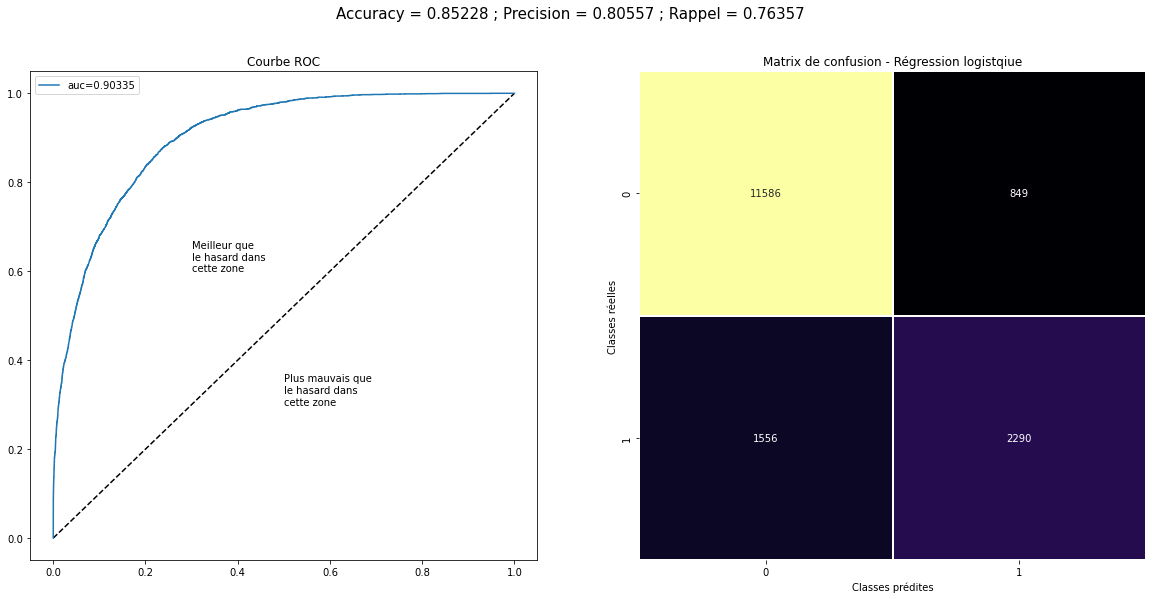

In [158]:
evaluation_model(reglog)

On va utiliser la `validation croisée` avec la méthode `StratifieldKFold` et `Cross_val_score` pour calculer le score à chaque découpage de la validation croisée.

In [155]:
scores = cross_val_score(reglog, X_train_processed, y_train)
print(scores)
print(np.mean(scores))

[0.84768924 0.84966216 0.85334767 0.85380835 0.85242629]
0.851386741731053


Création de nos hypêrparametres ôur la validation croisée

In [156]:
hyper_params = dict(C=[ 0.01, 0.1, 1, 10, 100, 1000], penalty=['l1', 'l2'])

In [160]:
reglog_cv = GridSearchCV(estimator=reglog, param_grid = hyper_params, cv=StratifiedKFold(5))
reglog_cv.fit(X_train_processed, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']})

In [164]:
#Affichage des hyperparametres optimaux et de Accuracy pour chaque modele

print("Meilleurs hyperparamètres sur le jeu d'entraineement")
print(reglog_cv.best_params_)

print("Les résultas de la validation croisée avec cahcun des paramètres: " )
for mean, std, params in zip(
    reglog_cv.cv_results_['mean_test_score'], 
    reglog_cv.cv_results_['std_test_score'], 
    reglog_cv.cv_results_['params'] ):
    print("'Accuracy' = {:.5f} (+/-{:.03f}) for {} ".format(mean, std*2, params))

Meilleurs hyperparamètres sur le jeu d'entraineement
{'C': 1, 'penalty': 'l2'}
Les résultas de la validation croisée avec cahcun des paramètres: 
'Accuracy' = 0.84506 (+/-0.008) for {'C': 0.01, 'penalty': 'l1'} 
'Accuracy' = 0.84838 (+/-0.005) for {'C': 0.01, 'penalty': 'l2'} 
'Accuracy' = 0.85059 (+/-0.006) for {'C': 0.1, 'penalty': 'l1'} 
'Accuracy' = 0.85086 (+/-0.005) for {'C': 0.1, 'penalty': 'l2'} 
'Accuracy' = 0.85093 (+/-0.005) for {'C': 1, 'penalty': 'l1'} 
'Accuracy' = 0.85139 (+/-0.005) for {'C': 1, 'penalty': 'l2'} 
'Accuracy' = 0.85086 (+/-0.005) for {'C': 10, 'penalty': 'l1'} 
'Accuracy' = 0.85090 (+/-0.004) for {'C': 10, 'penalty': 'l2'} 
'Accuracy' = 0.85074 (+/-0.004) for {'C': 100, 'penalty': 'l1'} 
'Accuracy' = 0.85071 (+/-0.005) for {'C': 100, 'penalty': 'l2'} 
'Accuracy' = 0.85074 (+/-0.004) for {'C': 1000, 'penalty': 'l1'} 
'Accuracy' = 0.85071 (+/-0.005) for {'C': 1000, 'penalty': 'l2'} 


`Sauvegarde du modèle avec le module pickle `

In [166]:
#Sauvergarde
filename = 'logistique_regression.csv'
pickle.dump(reglog_cv.best_estimator_, open(filename, 'wb'))

In [167]:
#Recharger le modele
logistique_sauvegarde = pickle.load(open(filename, 'rb'))
print(logistique_sauvegarde)

LogisticRegression(C=1, max_iter=1000, solver='liblinear')


`Autre modeles de classification`

`KNN`